In [17]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


# import tube images
path_images_correct = "../data/tubes"
train, test = tf.keras.utils.image_dataset_from_directory(
    path_images_correct,
    labels='inferred',
    label_mode='binary',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(100, 100),
    shuffle=True,
    seed=1234,
    validation_split=0.2,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 224 files belonging to 2 classes.
Using 180 files for training.
Using 44 files for validation.


In [18]:
class_names = train.class_names
print(class_names)

['connected', 'not connected']


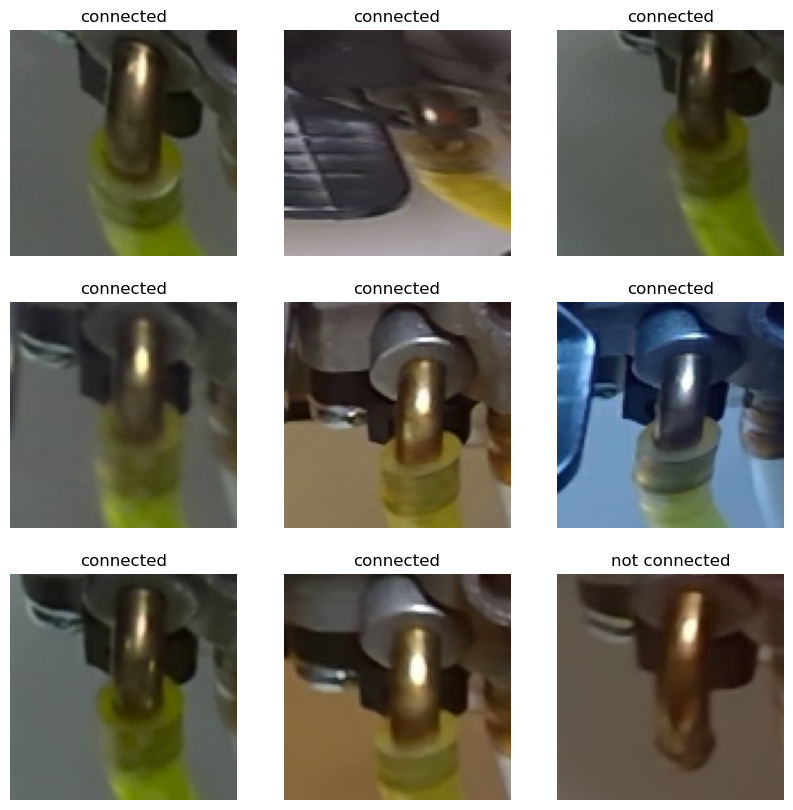

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [59]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test.cache().prefetch(buffer_size=AUTOTUNE)

In [60]:
normalization_layer = layers.Rescaling(1./255)

In [73]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 25, 25, 64)       

In [76]:
epochs=30
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)


Epoch 1/30
6/6 [==============================] - 1s 32ms/step - loss: 0.6556 - accuracy: 0.6556 - val_loss: 0.6292 - val_accuracy: 0.6818
Epoch 2/30
6/6 [==============================] - 0s 12ms/step - loss: 0.5620 - accuracy: 0.6944 - val_loss: 0.6004 - val_accuracy: 0.6136
Epoch 3/30
6/6 [==============================] - 0s 14ms/step - loss: 0.5023 - accuracy: 0.6944 - val_loss: 0.5634 - val_accuracy: 0.6136
Epoch 4/30
6/6 [==============================] - 0s 14ms/step - loss: 0.4117 - accuracy: 0.7611 - val_loss: 0.6167 - val_accuracy: 0.6136
Epoch 5/30
6/6 [==============================] - 0s 14ms/step - loss: 0.3845 - accuracy: 0.8333 - val_loss: 0.5784 - val_accuracy: 0.6364
Epoch 6/30
6/6 [==============================] - 0s 13ms/step - loss: 0.3701 - accuracy: 0.8056 - val_loss: 0.4983 - val_accuracy: 0.7727
Epoch 7/30
6/6 [==============================] - 0s 11ms/step - loss: 0.3084 - accuracy: 0.8722 - val_loss: 0.4912 - val_accuracy: 0.7727
Epoch 8/30
6/6 [===========

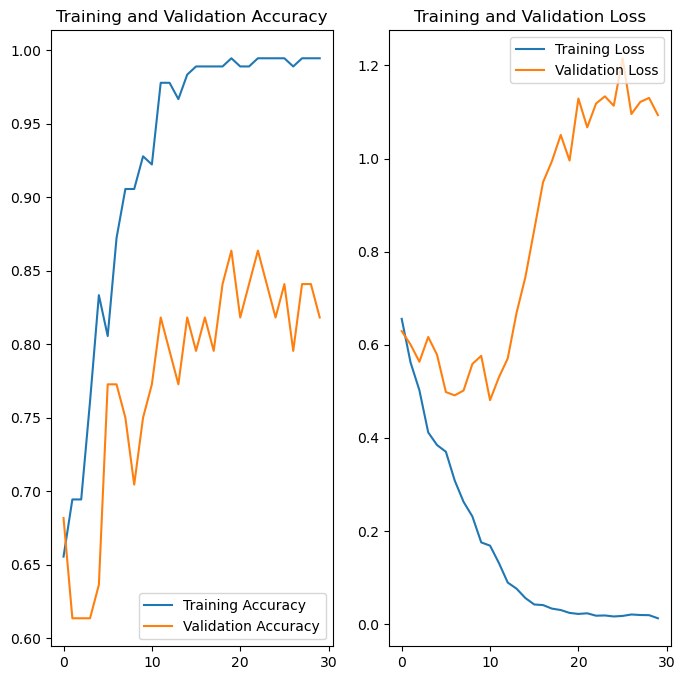

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [85]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(100,
                                  100,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

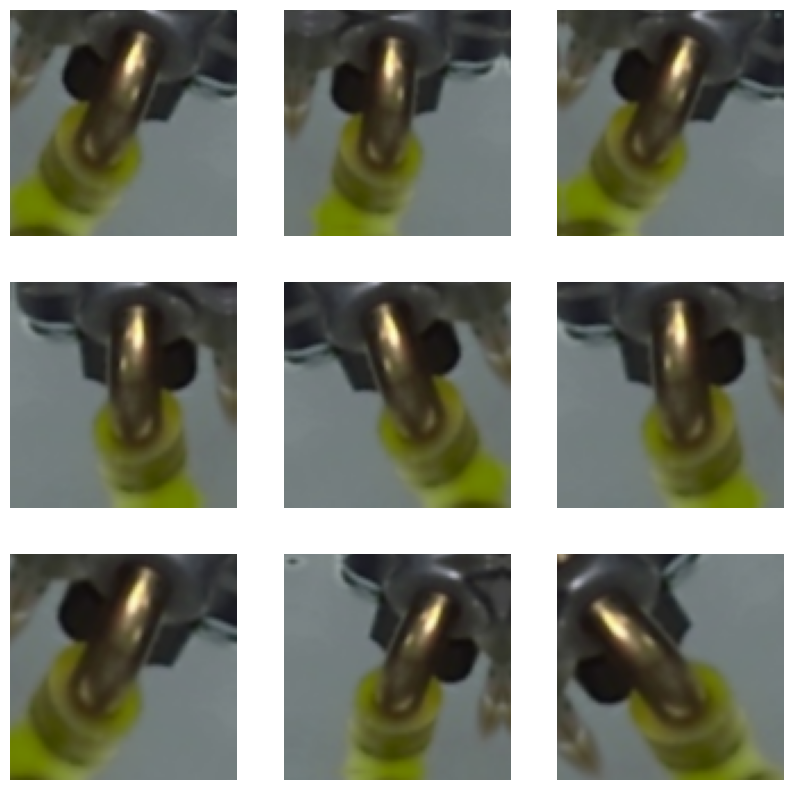

In [86]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [88]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [89]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [90]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 100, 100, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 25, 25, 32)       0         
 g2D)                                                 

In [91]:
epochs = 30
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/30


2023-06-03 18:00:30.850159: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - 2s 36ms/step - loss: 0.9541 - accuracy: 0.4556 - val_loss: 0.7225 - val_accuracy: 0.3182
Epoch 2/30
6/6 [==============================] - 0s 13ms/step - loss: 0.6830 - accuracy: 0.5500 - val_loss: 0.6393 - val_accuracy: 0.6818
Epoch 3/30
6/6 [==============================] - 0s 17ms/step - loss: 0.6417 - accuracy: 0.6556 - val_loss: 0.6294 - val_accuracy: 0.6818
Epoch 4/30
6/6 [==============================] - 0s 16ms/step - loss: 0.6438 - accuracy: 0.6556 - val_loss: 0.6472 - val_accuracy: 0.6818
Epoch 5/30
6/6 [==============================] - 0s 16ms/step - loss: 0.6344 - accuracy: 0.6556 - val_loss: 0.6152 - val_accuracy: 0.6818
Epoch 6/30
6/6 [==============================] - 0s 16ms/step - loss: 0.6208 - accuracy: 0.6556 - val_loss: 0.6078 - val_accuracy: 0.6818
Epoch 7/30
6/6 [==============================] - 0s 13ms/step - loss: 0.5992 - accuracy: 0.6556 - val_loss: 0.5819 - val_accuracy: 0.7045
Epoch 8/30
6/6 [======================

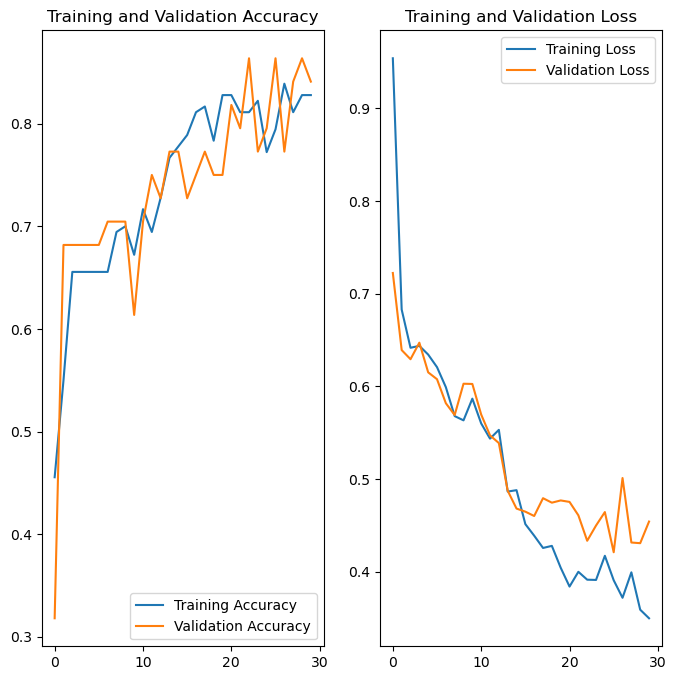

In [92]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
